In [1]:
import numpy as np
import g3utils as ut
import matplotlib.pyplot as plt
import so3g.proj
from spt3g import core
import pathlib

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"

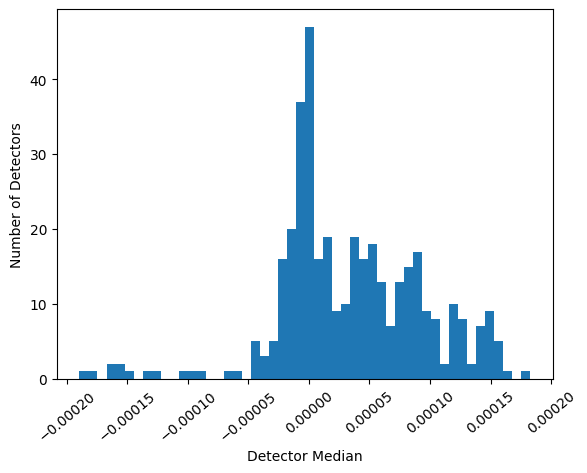

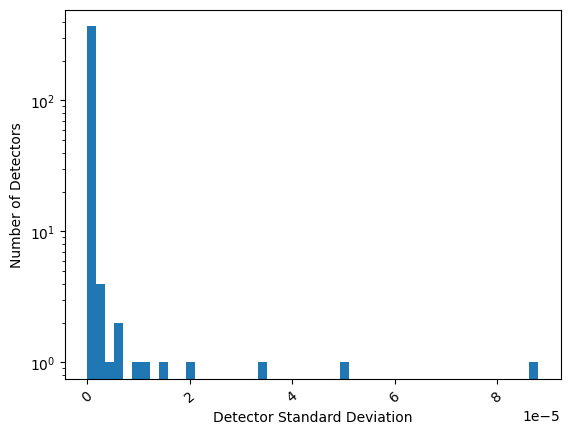

In [3]:
stats = ut.DetectorStats(data_key="df")

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(ra_df_added))
pipe.Add(stats)
pipe.Run()

# see signal_analysis.ipynb for plots of this data
detector_medians = np.median(np.array(stats.medians), axis=0)
detector_stds = np.median(np.array(stats.stds), axis=0)

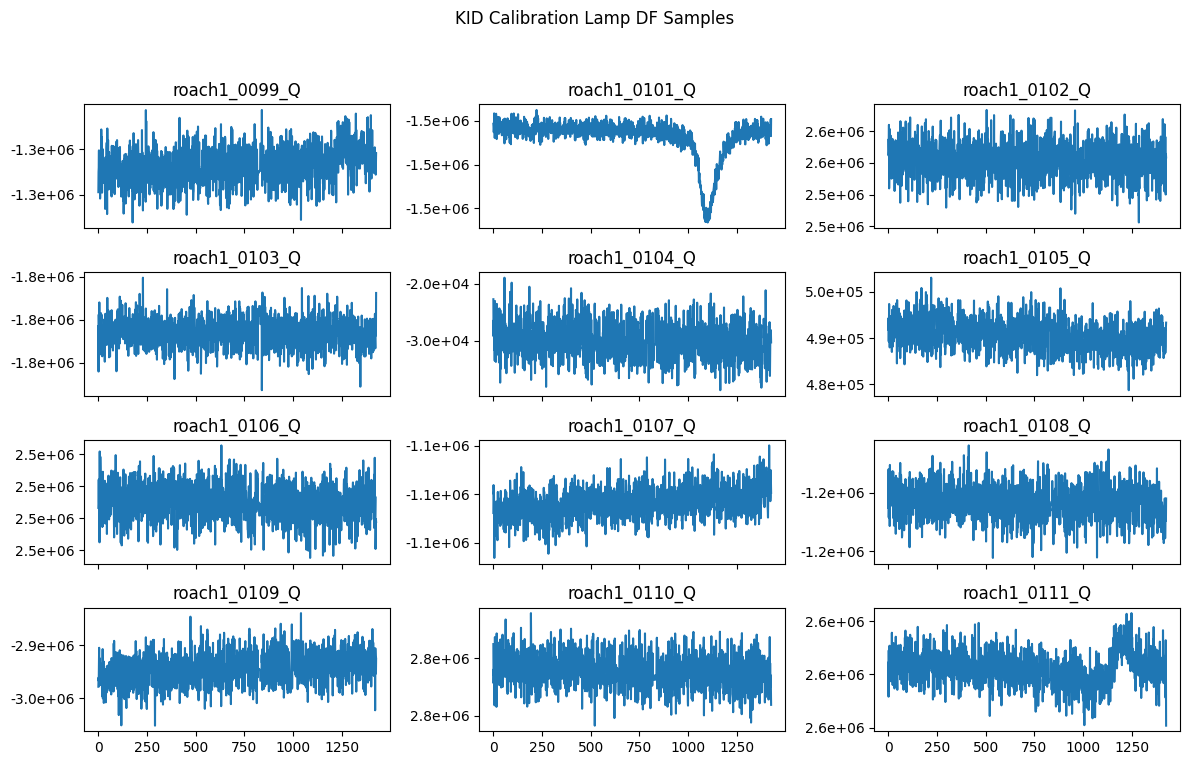

In [20]:
cf_grabber = ut.FirstFrameGrabber(frame_type=core.G3FrameType.Calibration)
nth_scan_grabber = ut.NthFrameGrabber(n=70, frame_type=core.G3FrameType.Scan)
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data")
pipe.Add(cf_grabber)
pipe.Add(nth_scan_grabber)
pipe.Run()

calframe = cf_grabber.first_frame
scanframe = nth_scan_grabber.nth_frame

fig, axs = plt.subplots(4, 3, figsize=(12, 8), sharex='all')
fig.suptitle("KID Calibration Lamp DF Samples")
axs = axs.flatten()
from matplotlib.ticker import FuncFormatter
def sci_notation(x, pos):
    return f'{x:.1e}'
for i, sample_idx in enumerate(range(481, 493)):
    axs[i].plot(scanframe["data"].data[sample_idx])
    axs[i].set_title(f"{scanframe['data'].names[sample_idx]}")
    axs[i].yaxis.set_major_formatter(FuncFormatter(sci_notation))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [41]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.AddScanDF)
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data")
pipe.Add(ut.NormalizeDF, detector_medians=detector_medians)
pipe.Add(ut.FrameCounter)
pipe.Add(core.G3Writer, filename=str(norm_df_added))
pipe.Run()

"""
Pipeline profiling results:
spt3g.core.G3Reader: 0.071389 user, 0.037763 system, 120 frames (0.000910 s per input frame)
_pipelineinfo: 0.000000 user, 0.000000 system, 120 frames (0.000000 s per input frame)
g3utils.add_radec_so3g: 0.197547 user, 0.000434 system, 120 frames (0.001650 s per input frame)
g3utils.AddScanDF: 25.434544 user, 0.064807 system, 120 frames (0.212495 s per input frame)
g3utils.add_cal_lamp_df: 0.281990 user, 0.009692 system, 120 frames (0.002431 s per input frame)
g3utils.NormalizeDF: 0.253910 user, 0.000002 system, 120 frames (0.002116 s per input frame)
g3utils.FrameCounter: 0.003378 user, 0.000064 system, 120 frames (0.000029 s per input frame)
spt3g.core.G3Writer: 3.151443 user, 0.251032 system, 120 frames (0.028354 s per input frame)
Total: 29.394201 user, 0.363794 system
Peak memory consumption (369.4 MB) in module g3utils.add_cal_lamp_df
"""


Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [53]:
def first_frame(file, type=core.G3FrameType.Scan):
    grabber = ut.FirstFrameGrabber(frame_type=type)
    pipe = core.G3Pipeline()
    pipe.Add(core.G3Reader, filename=file)
    pipe.Add(grabber)
    pipe.Run()
    return grabber.first_frame

kids = np.array(first_frame(str(norm_df_added))["norm_df"].names)

Found the first frame with type: Scan!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7fe272a99f60>'s first_frame attribute.


In [54]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1 * core.G3Units.arcmin

source_coords = {}
# determine source shifts
single_kid_binners = []
for kid in kids:
    binner = ut.SingleMapBinner(
        kid,
        timestreams="df",
        ra0=ra0,
        dec0=dec0,
        xlen=xlen,
        ylen=ylen,
        res=res
    )
    pipe = core.G3Pipeline()
    pipe.Add(core.G3Reader, filename=str(norm_df_added))
    pipe.Add(binner)
    pipe.Run()
    source_coords[kid] = binner.source_coords()
    single_kid_binners.append(binner)
    print(f"source_coords for {kid}: {source_coords[kid]}")

# for binner in single_kid_binners:
#     binner.plot()

/home/player1/map_making_jonah/blasttng-to-g3/g3utils.py:470: RuntimeWarning: invalid value encountered in divide
  zz = self.data / self.hits


source_coords for roach1_0292: (np.int64(16), np.int64(16))
source_coords for roach1_0157: (np.int64(20), np.int64(15))
source_coords for roach1_0007: (np.int64(23), np.int64(15))
source_coords for roach1_0170: (np.int64(41), np.int64(31))
source_coords for roach1_0378: (np.int64(54), np.int64(10))
source_coords for roach1_0147: (np.int64(34), np.int64(10))
source_coords for roach1_0173: (np.int64(46), np.int64(12))
source_coords for roach1_0220: (np.int64(22), np.int64(14))
source_coords for roach1_0203: (np.int64(22), np.int64(15))
source_coords for roach1_0016: (np.int64(18), np.int64(15))
source_coords for roach1_0072: (np.int64(17), np.int64(16))
source_coords for roach1_0377: (np.int64(36), np.int64(12))
source_coords for roach1_0291: (np.int64(40), np.int64(15))
source_coords for roach1_0334: (np.int64(51), np.int64(30))
source_coords for roach1_0090: (np.int64(16), np.int64(16))
source_coords for roach1_0280: (np.int64(14), np.int64(16))
source_coords for roach1_0330: (np.int64

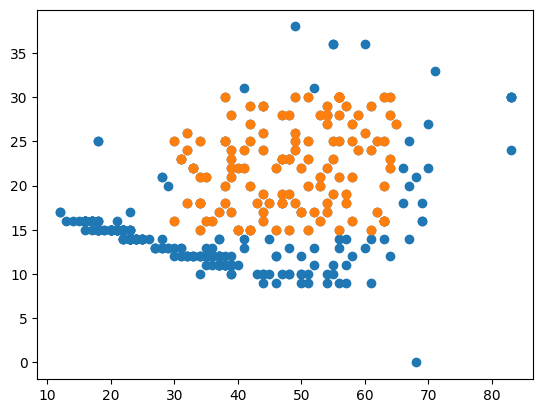

In [55]:
xs=[]
ys=[]
for key in source_coords.keys():
    xs.append(source_coords[key][0])
    ys.append(source_coords[key][1])
plt.scatter(xs, ys)

center_kids = [key for key in source_coords.keys() if (30 <= source_coords[key][0] <= 65) and (15 <= source_coords[key][1] <= 30)]

xs=[]
ys=[]
for key in center_kids:
    xs.append(source_coords[key][0])
    ys.append(source_coords[key][1])
plt.scatter(xs, ys)
plt.show()

In [58]:
rcw_92_min_lat = -77.110
rcw_92_max_lat = -77.070
rcw_92_min_lon = 162.20
rcw_92_max_lon = 162.55
rcw_92_min_alt = 36030
rcw_92_max_alt = 36120
rcw_92_avg_lat = rcw_92_min_lat / 2. + rcw_92_max_lat / 2.
rcw_92_avg_lon = rcw_92_min_lon / 2. + rcw_92_max_lon / 2.
rcw_92_avg_alt = rcw_92_min_alt / 2. + rcw_92_max_alt / 2.
BLASTTNG_SITE = so3g.proj.EarthlySite(rcw_92_avg_lon, rcw_92_avg_lat, rcw_92_avg_alt)  # we could also add weather


Calibration
PipelineInfo
Scan (x117)
EndProcessing


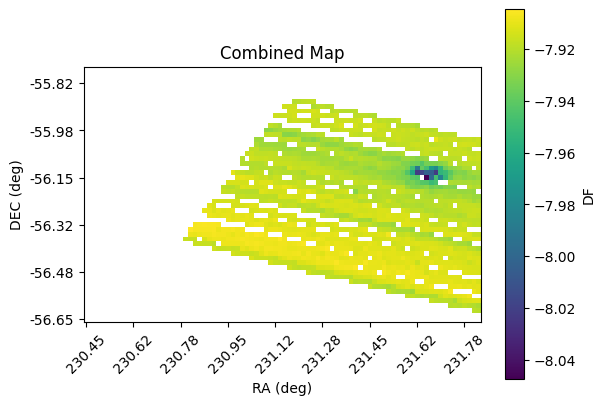

In [69]:
binner = ut.MapBinner(
    timestreams="norm_df",
    source_coords=source_coords,
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res,
    select_kids=[f"roach1_{kid:04}" for kid in (4,)],
    site=BLASTTNG_SITE
)

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

binner.plot()

In [ ]:
grabber = ut.FirstFrameGrabber(frame_type=core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_cal_lamp_df, roach_id=1, iq_key="cal_lamp_data")
pipe.Add(grabber)
pipe.Run()

cal_frame = grabber.first_frame

print(cal_frame)